In [2]:
!pip install evaluate
!pip install datasets
!pip install transformers[sentencepiece]
!pip install peft
!pip install rouge_score

# NLP, DS-поток
## Задание 4
### Parameter-Efficient Fine-Tuning.

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.


**Баллы за задание.**
  * Работа с данными &mdash; 10 баллов;
  * Обучение моделей &mdash; 80 баллов;
  * Оценка качества &mdash; 40 баллов;
  * Сравнение моделей &mdash; 20 баллов.


In [2]:
# Bot check

# HW_ID: ds_nlp4
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [3]:
import transformers
import evaluate

import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, palette="Set2")

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset

from transformers import (
    AutoTokenizer,
    AutoModel,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    default_data_collator
)

from transformers import T5ForConditionalGeneration, T5Tokenizer

from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    TaskType,
    LoraConfig
)
from rouge_score import rouge_scorer

from tqdm.auto import tqdm
from pathlib import Path

from sklearn.model_selection import train_test_split

## Описание задачи

В этом домашнем задании мы будем работать c моделью [ruT5](https://habr.com/ru/company/sberbank/blog/567776/) на данных новостей с портала [Газета.Ru](https://www.kaggle.com/datasets/phoenix120/gazeta-summaries) над задачей суммаризации новостей. Обычно при обсуждении задачи суммаризации выделяют два основных подхода:
* **Экстрактивная суммаризация.** В этом случае из исходного текста выделяются наиболее важные фрагменты, ключевые слова, которые и будут являться сжатым содержанием.
* **Абстрактивная суммаризация.** Этот подход отличается тем, что краткое содержание исходного текста порождается некоторой генеративной моделью.

В этом домашнем задании мы решаем задачу абстрактивной суммаризации. При решении задачи мы не будем обучать модель целиком, а попробуем применить некоторые подходы эффективного по параметрам обучения с помощью библиотеки [PEFT](https://github.com/huggingface/peft).

Надо оговориться, что идея применения T5-based архитектур для решения задач суммаризации на русском языке [не нова](https://sbercloud.ru/ru/datahub/rugpt3family/summarizer). Основной смысл задания состоит в том, чтобы реализовать полный пайплайна частичного обучения модели с помощью библиотеки `peft` и оценить получившееся качество. При выполнении задания **не разрешается** использовать предобученные на этой задаче модели, например [такую](https://huggingface.co/IlyaGusev/rut5_base_sum_gazeta). Мы будем использовать модели, обученные только на задачу денойзинга, то есть `ruT5-base` или, при наличии ресурсов, `ruT5-large`.

Рассмотрим пример генерации с помощью `ruT5-base` для задачи денойзинга или заполнения слотов. Для инференса `transformers` предоставляет удобный метод `.generate(...)`. В зависимоcти от переданных параметров можно генерировать  с использованием жадной стратегии, сэмплирования с температурой, top-k или top-p сэмплирования, а также использовать beam search. Рекомендуется ознакомиться с [постом](https://huggingface.co/blog/how-to-generate), в котором показаны примеры применения различных стратегий декодирования. Если у вас есть некоторые сомнения, связанные с пониманием работы полноценного трансформера с encoder-decoder архитектурой, то рекомендуется ознакомиться также с [этим](https://huggingface.co/blog/encoder-decoder#encoder-decoder) постом.

In [11]:
model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
tokenizer = T5Tokenizer.from_pretrained("ai-forever/ruT5-base")

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
input_ids = tokenizer(
    "Снижение цен <extra_id_0> в Москве возможно только при <extra_id_1> " +
    "Это условие названо в аналитической заметке портала Новости <extra_id_2> ",
    return_tensors='pt'
)["input_ids"]

out_ids = model.generate(
    input_ids=input_ids,                 # послд-ть входных токенов, в нашем случае вход декодера
    max_length=64,                       # макс. длина ген. послед-ти
    eos_token_id=tokenizer.eos_token_id, # eos токен
    num_beams=5,                         # указываем num_beams - будет использован beam_search
)

tokenizer.decode(out_ids[0])

'<pad> <extra_id_0> на жилье <extra_id_1> соблюдении ряда условий. <extra_id_2> Москвы</s>'

Обратите внимание, что роль bos-токена играет `<pad>`. Далее, пропуски`<extra_id_X>` раскрываются в возможные фрагменты текста. В данном случае `<extra_id_0>`, `<extra_id_1>` и т.п. &mdash; это спец токены, которые которые модель должна заполнить, тем самым решая задачу денойзинга. Т.к. T5 &mdash; полноценный трансформер, на вход энкодера во время предобучения приходит текст с этими спец. токенами, а на вход декодера – те последовательности, что долны быть на месте спец. токенов.

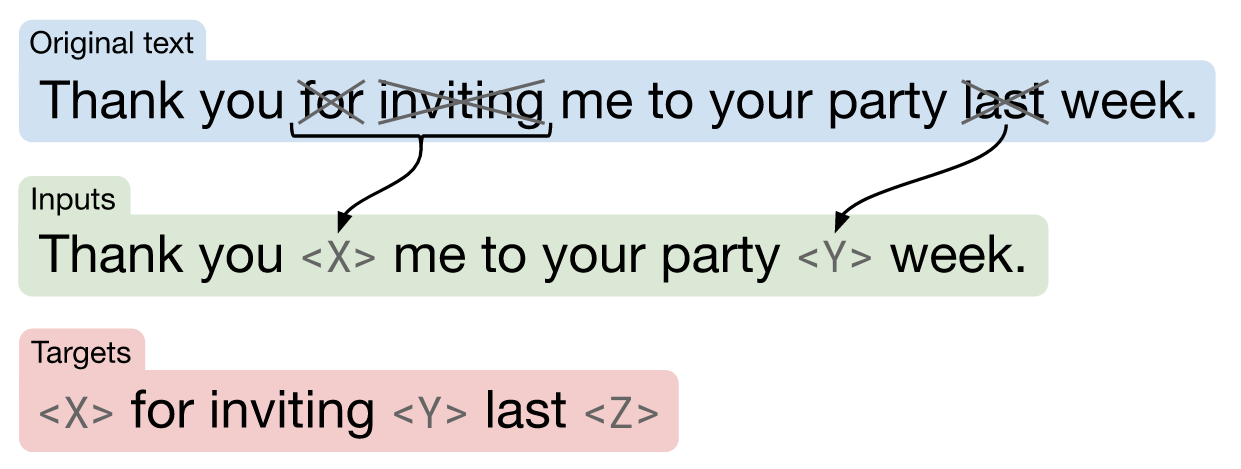

## Работа с данными

Теперь загрузим данные. Если при решении задания у вас возникнут проблемы из-за большого объема данных, например, не будет хватать оперативной памяти, то **можете взять подвыборку разумного** размера из обучающего и валидационного датасета.

In [4]:
dataset = load_dataset("IlyaGusev/gazeta", revision="v1.0", trust_remote_code=True)

README.md:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

gazeta.py:   0%|          | 0.00/2.98k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

gazeta_train.jsonl:   0%|          | 0.00/471M [00:00<?, ?B/s]

gazeta_val.jsonl:   0%|          | 0.00/48.6M [00:00<?, ?B/s]

gazeta_test.jsonl:   0%|          | 0.00/52.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

In [7]:
dataset.keys()

dict_keys(['train', 'test', 'validation'])

In [12]:
train_data = dataset["train"]
train_data = train_data.select(range(len(train_data) // 10))
val_data = dataset["validation"]
val_data = val_data.select(range(len(train_data) // 4))

Посмотрим, из чего состоит обучающий пример. Нас будут интересовать поля `text`, `summary`.

In [9]:
train_data[13]

{'text': 'Российскому певцу Андрею Губину исполнилось 45 лет. Последнее время артист залег на дно и перестал радовать поклонников новыми хитами и полностью отказался от концертов. В одном из немногочисленных интервью, Губин жаловался на свое здоровье, указывая на проблемы нервной системы. По словам музыканта, врачи не уделили ему должного внимания, в связи с чем ему приходится бороться с проблемой самостоятельно. Продюсер «Ласкового мая» Андрей Разин рассказал о том, что он пытается помочь Губину. Разин подтвердил, что у звезды 90-х действительно серьезные проблемы, однако, по его мнению, это проблемы психического характера: «У Андрея серьезные проблемы с психикой. Ему мерещится, что у него постоянно чешется и болит лицо. Мы его водили по врачам, они ничего не нашли». Он также отметил, что с певцом стало очень тяжело говорить, поскольку тот стал чрезмерно вспыльчивым и ранимым, неадекватно воспринимая все попытки ему помочь, сообщает издание Bimru. По некоторой информации, покинув сцен

Выделим необходимые поля.

In [13]:
train_text = [tmp_dict["text"] for tmp_dict in train_data]
train_summary = [tmp_dict["summary"] for tmp_dict in train_data]

val_text = [tmp_dict["text"] for tmp_dict in val_data]
val_summary = [tmp_dict["summary"] for tmp_dict in val_data]

Соберем датасеты.

In [14]:
train_dataset = Dataset.from_dict({
    "text": train_text,
    "summary": train_summary
})

val_dataset = Dataset.from_dict({
    "text": val_text,
    "summary": val_summary
})

Посмотрим на распределение длин

Tokenizing train texts:   0%|          | 0/5240 [00:00<?, ?it/s]

Tokenizing train summaries:   0%|          | 0/5240 [00:00<?, ?it/s]

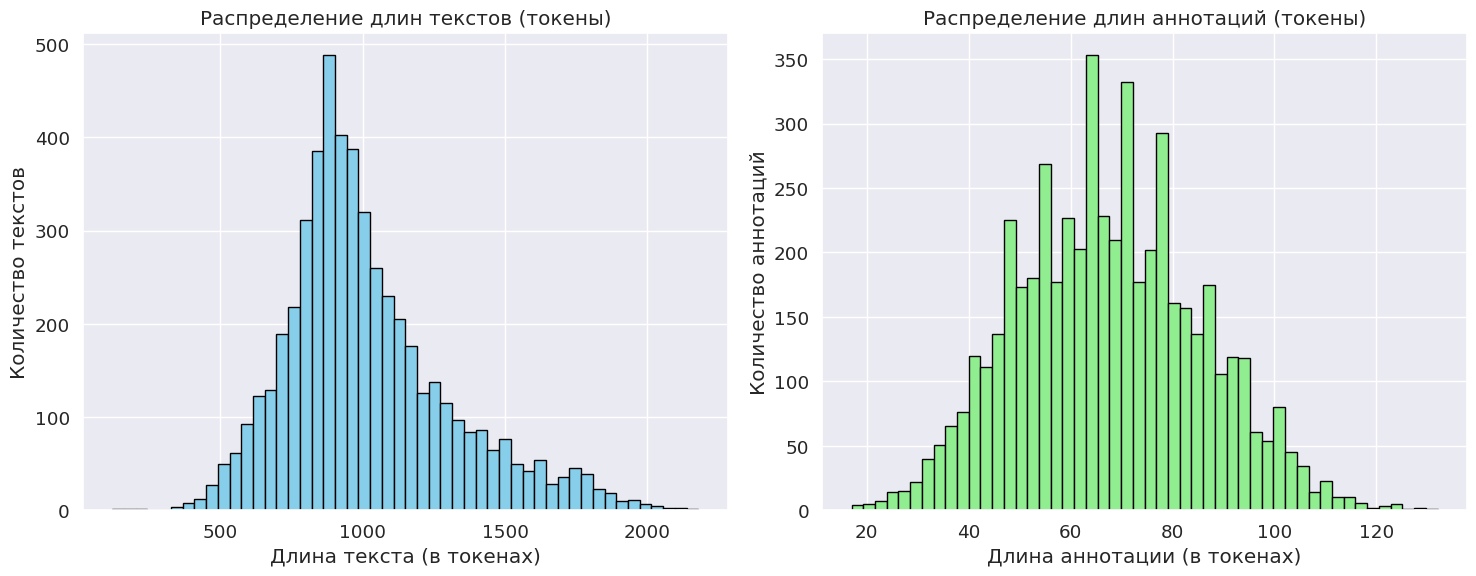

In [12]:
train_text_token_lengths = [len(tokenizer.tokenize(text)) for text in tqdm(train_dataset["text"], desc="Tokenizing train texts")]
train_summary_token_lengths = [len(tokenizer.tokenize(summary)) for summary in tqdm(train_dataset["summary"], desc="Tokenizing train summaries")]

# Создаем подграфики
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# График для 'text'
axes[0].hist(train_text_token_lengths, bins=50, color='skyblue', edgecolor='black')
axes[0].set_title("Распределение длин текстов (токены)")
axes[0].set_xlabel("Длина текста (в токенах)")
axes[0].set_ylabel("Количество текстов")
axes[0].grid(True)

# График для 'summary'
axes[1].hist(train_summary_token_lengths, bins=50, color='lightgreen', edgecolor='black')
axes[1].set_title("Распределение длин аннотаций (токены)")
axes[1].set_xlabel("Длина аннотации (в токенах)")
axes[1].set_ylabel("Количество аннотаций")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Напишем функцию для препроцессинга наших данных. Архитектурно модель `ruT5` &mdash; это полноценный трансформер. На вход модели будет поступать исходный текст новости, по которому она будет пытаться сгенерировать его сжатое саммари.

In [15]:
def preprocess_function(examples):
    """ Функция препроцессинга для обработки данных. """

    # выделим input / targets для модели
    inputs = examples["text"]
    targets = examples["summary"]
    # токенизируем новости, это вход энкодера
    # наша source-последовательность
    model_inputs = tokenizer(inputs,
                             max_length=512, # Больше поставить не могу -- не хватает видеопамяти 
                             padding="max_length",
                             truncation=True,
                             return_tensors="pt")
    # токенизируем саммари, это входе декодера во время обучения
    # то есть наша target-последовательность
    labels = tokenizer(targets,
                       max_length=128,
                       padding="max_length",
                       truncation=True,
                       return_tensors="pt")
    # не будем считать лосс для паддинга
    # по умолчанию nn.CrossEntropy не учитыает в лоссе объекты с меткой -100
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100

    # сформируем вход для нашей модели
    model_inputs["labels"] = labels[0]
    model_inputs["input_ids"] = model_inputs["input_ids"][0]
    model_inputs["attention_mask"] = model_inputs["attention_mask"][0]
    return model_inputs

Применим препроцессинг к датасету. Обратите внимание, что паддинг мы сделали заранее. Понятно, что это не очень эффективно. При желании рекомендуется это исправить, то есть перенести паддинг на момент формирования батча в data collator. Заметим также, что саммари обычно гораздо меньше исходной новости, поэтому выставлять `max_length` следует аккуратно.

In [16]:
train_dataset = train_dataset.map(
    preprocess_function,
    num_proc=2,
    desc="Running tokenizer on train dataset...",
)

val_dataset = val_dataset.map(
    preprocess_function,
    num_proc=2,
    desc="Running tokenizer on val dataset...",
)

Running tokenizer on train dataset... (num_proc=2):   0%|          | 0/5240 [00:00<?, ? examples/s]

Running tokenizer on val dataset... (num_proc=2):   0%|          | 0/1310 [00:00<?, ? examples/s]

## Обучение моделей

В библиотеке [`PEFT`](https://github.com/huggingface/peft) представлены различные подходы к эффективному по параметрам обучению. Рассмотрим некоторые из них.

### LoRA

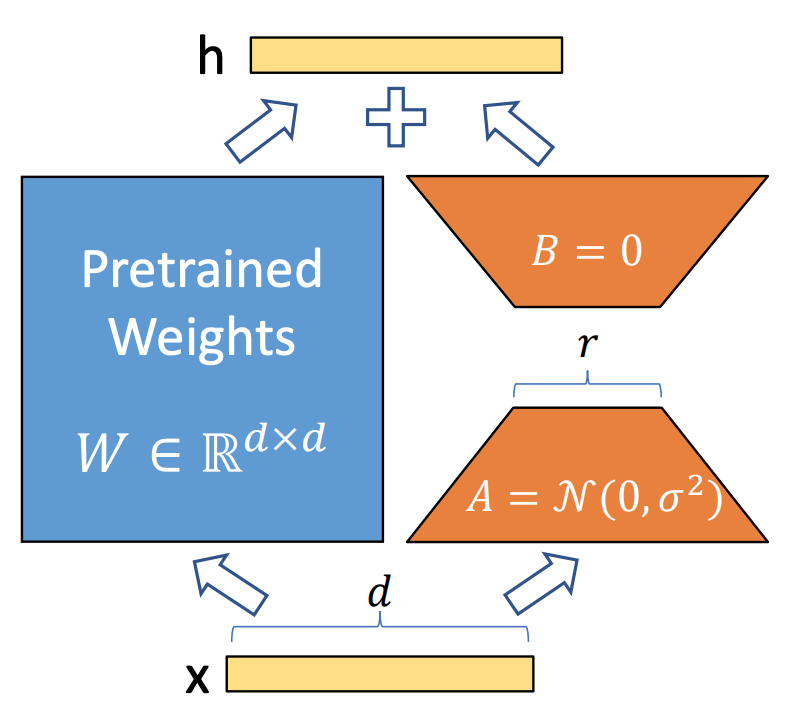

Позволяет повысить эффективность обучения посредством использования low-rank аппроксимации для матриц. Подробнее про метод и его использование можете прочитать [здесь](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora).

### IA^3
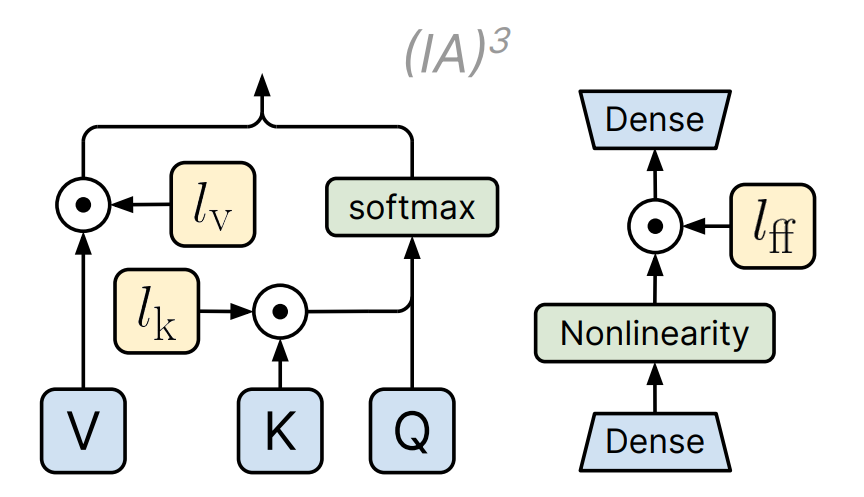

Метод IA3 (Infused Adapter by Inhibiting and Amplifying Inner Activations) добавляет в модель обучемые векторы $l_v$, $l_k$ и $l_{ff}$, которые умножаются (поэлементно) на соответствующие выходы слоев модели (см. изображение), таким образом добиваясь обучаемого рескейлинга. Обучение модели с таким адаптером получается даже эффективнее, чем обучение с использованием LoRA, и при этом результаты оказываются сопоставимыми с обычным fine-tuning.

Подробнее про подход можно прочитать [тут](https://huggingface.co/docs/peft/conceptual_guides/ia3).

Задать соотвествующий конфиг `peft`'a для нашей задачи можно так:
```
from peft import IA3Config, TaskType
peft_config = IA3Config(task_type=TaskType.SEQ_2_SEQ_LM, # задача seq2seq
                        inference_mode=False,
                        target_modules=...             # опционально можно задать  
                        feedforward_modules=...)       # target_modules / feedforward_modules
```

Обратите внимание, для LoRA также нужно будет указать верный `task_type`. На занятии мы рассматривали простую задачу классификации, а здесь же seq2seq.

Итак, вам предлагается обучить модели с использованием вышеописанных методов и сравнить их с обычным обычным fine-tuning'ом модели. Подумайте, какие преимущества и недостатки есть у каждого подхода.

Сравните модели при добавлении адаптер-слоев в различные модули. Попробуйте **2-3 варианта для каждого метода**. Для этого обратите внимание на аргументы `target_modules` и `feedforward_modules` во время конфигураций адаптеров. Мы используем модель на базе T5, по умолчанию в `peft` уже перечислены модули, в которые внедряются адаптеры для разных моделей. Например, для [LoRA](https://github.com/huggingface/peft/blob/9119b780ebac7859db5753ebad50d94ba803c99c/src/peft/utils/constants.py#L49) это `q` и `v` на каждом слое, а для [IA3](https://github.com/huggingface/peft/blob/9119b780ebac7859db5753ebad50d94ba803c99c/src/peft/utils/constants.py#L83)  &mdash; это `k`, `v` и `wo`.

Для LoRA попробуйте также различные 2-3 варианта гиперпараметра `r` через библиотеку `peft`. А также реализуйте свой кастомный слой-обертку в виде LoRA-адаптера над линейными слоями аттеншена в модулях `q` и `v`, обучите и сравните свою реализацию с реализацией через `peft`.

Начнем с собственной реализации LoRA-адаптера.


In [14]:
class LoRALayerWrapper(nn.Module):
    def __init__(self, original_layer, rank=8, alpha=16):
        super().__init__()
        self.original_layer = original_layer
        self.original_layer.requires_grad_(False)

        in_features = original_layer.in_features
        out_features = original_layer.out_features

        # Инициализация LoRA-параметров
        self.lora_A = nn.Parameter(torch.empty(in_features, rank))
        self.lora_B = nn.Parameter(torch.empty(rank, out_features))
        self.scaling = alpha / rank

        # Инициализация весов
        nn.init.zeros_(self.lora_B)
        nn.init.normal_(self.lora_A, mean=0.0, std=1.0)

    def forward(self, input):
        original_output = self.original_layer(input)
        lora_output = self.scaling * input @ self.lora_A @ self.lora_B
        return original_output + lora_output

Проверим реализацию, сравнив ее с той, что предоставляет `peft`.

In [16]:
torch.manual_seed(42)
rank = 4
alpha = 32
dummy_input = torch.randn(1, 1, 768)

# Реализация через peft
peft_config = LoraConfig(
    r=rank,
    lora_alpha=alpha,
    target_modules=["q", "v"],
    lora_dropout=0.0,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
peft_model = get_peft_model(base_model, peft_config)

In [17]:
# возьмем один модуль для простого теста
q_layer_to_test = peft_model.base_model.encoder.block[0].layer[0].SelfAttention.q
# исходный линейный слой
base_linear_layer = q_layer_to_test.base_layer
# наша обертка
our_model = LoRALayerWrapper(base_linear_layer, rank=rank, alpha=alpha)

our_output = our_model(dummy_input)
peft_output = q_layer_to_test(dummy_input)
assert torch.allclose(our_output, peft_output, atol=1e-4), "Что-то не так с простым forward"

Тест выше совсем простой, т.к. из-за особенности инициализации изначально LoRA ничего не делает. Добавим чуть более сложный тест-кейс.

In [18]:
dummy_B = torch.randn_like(our_model.lora_B.data)

with torch.no_grad():
    # скопируем параметры
    our_model.lora_B.data.copy_(dummy_B)
    q_layer_to_test.lora_B.default.weight.data.copy_(dummy_B.T)
    our_model.lora_A.data.copy_(q_layer_to_test.lora_A.default.weight.data.T)

# forward + backward pass для реализаций
our_output = our_model(dummy_input)
our_loss = our_output.sum()
our_loss.backward()

peft_output = q_layer_to_test(dummy_input)
peft_loss = peft_output.sum()
peft_loss.backward()

In [19]:
our_grad_A = our_model.lora_A.grad
peft_grad_A = q_layer_to_test.lora_A.default.weight.grad.T

our_grad_B = our_model.lora_B.grad
peft_grad_B = q_layer_to_test.lora_B.default.weight.grad.T

assert torch.allclose(our_grad_A, peft_grad_A, atol=1e-4), "Расхождения градиентов для матрицы A"
assert torch.allclose(our_grad_B, peft_grad_B, atol=1e-4), "Расхождения градиентов для матрицы B"

Теперь напишем функцию для оборачивания модулей `q`, `v` через реализованный слой.

In [20]:
print(model.encoder.block[0].layer[0].SelfAttention.__dict__)

{'training': False, '_parameters': {}, '_buffers': {}, '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': {'q': Linear(in_features=768, out_features=768, bias=False), 'k': Linear(in_features=768, out_features=768, bias=False), 'v': Linear(in_features=768, out_features=768, bias=False), 'o': Linear(in_features=768, out_features=768, bias=False), 'relative_attention_bias': Embedding(32, 12)}, 'is_decoder': False, 'has_relative_attention_bias': True, 'relative_attention_num_buckets': 32, 'relative_attention_max_dista

In [21]:
def inject_lora(model, rank, alpha):
    # Энкодер
    for encoder_block in model.encoder.block:
        self_attn = encoder_block.layer[0].SelfAttention
        self_attn.q = LoRALayerWrapper(self_attn.q, rank, alpha)
        self_attn.v = LoRALayerWrapper(self_attn.v, rank, alpha)

    # Декодер
    for decoder_block in model.decoder.block:
        # Self attention
        self_attn = decoder_block.layer[0].SelfAttention
        self_attn.q = LoRALayerWrapper(self_attn.q, rank, alpha)
        self_attn.v = LoRALayerWrapper(self_attn.v, rank, alpha)

        # Cross attention
        cross_attn = decoder_block.layer[1].EncDecAttention
        cross_attn.q = LoRALayerWrapper(cross_attn.q, rank, alpha)
        cross_attn.v = LoRALayerWrapper(cross_attn.v, rank, alpha)


    # Замораживаем все параметры, размораживаем только LoRA-матрицы
    for name, param in model.named_parameters():
        if "lora" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model

Отлично, теперь можно приступить к экспериментам. Не забудьте сравнить свою реализацию LoRA c аналогичной через `peft`.

In [17]:
def collate_fn(batch):
    input_ids = torch.tensor([item["input_ids"] for item in batch], dtype=torch.long)
    attention_mask = torch.tensor([item["attention_mask"] for item in batch], dtype=torch.long)
    labels = torch.tensor([item["labels"] for item in batch], dtype=torch.long)
    
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

In [18]:
def compute_rouge(model, tokenizer, val_loader, device="cpu"):
    rouge = evaluate.load("rouge")
    rouge_scores = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}
    total_samples = 0
    
    for val_data in tqdm(val_loader, desc="scoring"):
        inputs = val_data["input_ids"].to(device)
        attention = val_data["attention_mask"].to(device)
        labels = val_data["labels"].to(device)

        with torch.no_grad():
            model.eval()
            # Генерация с ускоренными параметрами
            generated_ids = model.module.generate(
                input_ids=inputs,
                attention_mask=attention,
                max_length=128,
                min_length=30,  # Чтоб не было слишком коротко
                num_beams=4,    # Улучшает качество
                temperature=0.7, # Делает ответы разнообразнее
                top_k=50,       # Обрезает редкие токены
                repetition_penalty=1.2, # Меньше повторений
                do_sample=True   # Для большего разнообразия
            )
                        # Пакетное декодирование
            predicted_texts = tokenizer.batch_decode(
                generated_ids, 
                skip_special_tokens=True, 
                clean_up_tokenization_spaces=True
            )
            valid_labels = [
                [token_id for token_id in seq if token_id != -100] 
                for seq in labels.cpu().numpy()
            ]
            reference_texts = tokenizer.batch_decode(
                valid_labels, 
                skip_special_tokens=True
            )
            
            # Пакетный подсчёт ROUGE
            results = rouge.compute(
                predictions=predicted_texts,
                references=reference_texts,
                use_stemmer=True
            )
            for key in rouge_scores:
                rouge_scores[key] += results[key]
            total_samples += len(predicted_texts)

    # Усреднение
    for key in rouge_scores:
        rouge_scores[key] /= total_samples if total_samples != 0 else 1

    return rouge_scores

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [19]:
def train_model_with_rouge(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, device, tokenizer):
    train_loss_list, test_loss_list, test_rouge_list = [], [], []

    # Если доступно несколько GPU, используем DataParallel
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = torch.nn.DataParallel(model)

    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()

        total_train_loss = 0.0
        num_batches = 0
        j = 0
        for i, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - training")):
            inputs = data["input_ids"].to(device)
            attention = data["attention_mask"].to(device)
            labels = data["labels"].to(device)

            optimizer.zero_grad()

            # Прямой проход
            output = model(input_ids=inputs, attention_mask=attention, labels=labels)
            logits = output.logits

            # Лосс для CrossEntropy
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))

            # Обратное распространение
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            num_batches += 1

            if (i + 1) % 10 == 0:
                avg_train_loss = total_train_loss / num_batches
                train_loss_list.append(avg_train_loss)
                total_train_loss = 0.0
                num_batches = 0

        # Вычисление лосса на валидации после каждой эпохи
        model.eval()
        total_val_loss = 0.0
        num_batches = 0
        epoch_val_losses = []

        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader, desc="validating")):
                inputs = data["input_ids"].to(device)
                attention = data["attention_mask"].to(device)
                labels = data["labels"].to(device)

                output = model(input_ids=inputs, attention_mask=attention, labels=labels)
                logits = output.logits

                # Лосс для CrossEntropy на валидации
                loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
                total_val_loss += loss.item()
                num_batches += 1

                if (i + 1) % 10 == 0:
                    avg_val_loss = total_val_loss / num_batches
                    epoch_val_losses.append(avg_val_loss)
                    total_val_loss = 0.0
                    num_batches = 0

        # Средний лосс за эпоху
        if epoch_val_losses:
            epoch_avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        else:
            epoch_avg_val_loss = 0.0
        test_loss_list.append(epoch_avg_val_loss)

        # Вычисление ROUGE на валидационном наборе
        rouge_scores = compute_rouge(model, tokenizer, val_loader, device)
        test_rouge_list.append(rouge_scores)

        # Логируем результаты для текущей эпохи
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Validation Loss: {epoch_avg_val_loss:.4f}")
        print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}, ROUGE-2: {rouge_scores['rouge2']:.4f}, ROUGE-L: {rouge_scores['rougeL']:.4f}")

    return train_loss_list, test_loss_list, test_rouge_list

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
our_model_lora_8 = inject_lora(base_model, 8, 16)

our_model_lora_8 = our_model_lora_8.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(our_model_lora_8.parameters(), lr=1e-3)
num_epochs = 3

train_loss_our_lora_8, test_loss_our_lora_8, test_rogue_our_lora_8 = train_model_with_rouge(
    our_model_lora_8,
    train_dataloader,
    val_dataloader,
    loss_fn,
    optimizer,
    num_epochs,
    device,
    tokenizer
)

Using 2 GPUs!


Epoch 1/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 1/3
Validation Loss: 4.4493
ROUGE-1: 0.0002, ROUGE-2: 0.0000, ROUGE-L: 0.0002


Epoch 2/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 2/3
Validation Loss: 2.8874
ROUGE-1: 0.0042, ROUGE-2: 0.0010, ROUGE-L: 0.0041


Epoch 3/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 3/3
Validation Loss: 2.6316
ROUGE-1: 0.0084, ROUGE-2: 0.0018, ROUGE-L: 0.0082


In [27]:
peft_config = LoraConfig(
    r=8,  # Размер слоя
    lora_alpha=16,  # Коэффициент Lora
    target_modules=["q", "v"],  # Выбираем модули для дообучения
    lora_dropout=0.1,  # Дропаут для Lora
    bias="none"  # Используем без смещения
)

# Применение PEFT к модели
base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
peft_lora_8_model = get_peft_model(base_model, peft_config)
peft_lora_8_model = peft_lora_8_model.to(device)

# Функция для вычисления лосса
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(peft_lora_8_model.parameters(), lr=1e-3)

train_loss_peft_lora_8, test_loss_peft_lora_8, test_rogue_peft_lora_8 = train_model_with_rouge(peft_lora_8_model,
                                                                                               train_dataloader,
                                                                                               val_dataloader,
                                                                                               loss_fn,
                                                                                               optimizer,
                                                                                               num_epochs,
                                                                                               device,
                                                                                               tokenizer)

Using 2 GPUs!


Epoch 1/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 1/3
Validation Loss: 2.1793
ROUGE-1: 0.0106, ROUGE-2: 0.0025, ROUGE-L: 0.0104


Epoch 2/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 2/3
Validation Loss: 2.1283
ROUGE-1: 0.0110, ROUGE-2: 0.0024, ROUGE-L: 0.0107


Epoch 3/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 3/3
Validation Loss: 2.1521
ROUGE-1: 0.0111, ROUGE-2: 0.0026, ROUGE-L: 0.0109


In [28]:
def count_parameters(model, title="T5 model"):
    # Считаем общее количество параметров
    total_params = sum(p.numel() for p in model.parameters())

    # Считаем количество обучаемых параметров
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Считаем количество не обучаемых параметров
    non_trainable_params = total_params - trainable_params

    # Выводим результаты
    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"Non-Trainable Parameters: {non_trainable_params}")

In [28]:
def plot_training_results(train_loss_lists, test_loss_lists, test_rouge_lists, model_names):
    # График потерь (Train и Validation)
    plt.figure(figsize=(10, 6))
    for i, train_loss in enumerate(train_loss_lists):
        plt.plot(train_loss, label=f"Train Loss - {model_names[i]}")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    for i, test_loss in enumerate(test_loss_lists):
        plt.plot(test_loss, label=f"Validation Loss - {model_names[i]}")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.show()

    # График ROUGE для каждой модели
    plt.figure(figsize=(10, 6))
    for i, rouge_scores in enumerate(test_rouge_lists):
        rouge1_scores = [score['rouge1'] for score in rouge_scores]
        rouge2_scores = [score['rouge2'] for score in rouge_scores]
        rougeL_scores = [score['rougeL'] for score in rouge_scores]

        plt.plot(rouge1_scores, label=f"ROUGE-1 - {model_names[i]}")
        plt.plot(rouge2_scores, label=f"ROUGE-2 - {model_names[i]}")
        plt.plot(rougeL_scores, label=f"ROUGE-L - {model_names[i]}")
    
    plt.xlabel('Epochs')
    plt.ylabel('ROUGE Score')
    plt.title('ROUGE Scores Over Epochs')
    plt.legend()
    plt.show()

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создание и обучение модели с LoRA (rank=16) через inject_lora
base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
our_model_lora_16 = inject_lora(base_model, 16, 16)  # rank=16
our_model_lora_16 = our_model_lora_16.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(our_model_lora_16.parameters(), lr=1e-3)

train_loss_our_lora_16, test_loss_our_lora_16, test_rogue_our_lora_16 = train_model_with_rouge(
    our_model_lora_16,
    train_dataloader,
    val_dataloader,
    loss_fn,
    optimizer,
    num_epochs,
    device,
    tokenizer
)

# Конфигурация LoRA с rank=16 для PEFT
peft_config_16 = LoraConfig(
    r=16,  # Rank=16
    lora_alpha=16,  # Коэффициент LoRA
    target_modules=["q", "v"],  # Выбираем модули для дообучения
    lora_dropout=0.1,  # Дропаут для LoRA
    bias="none"  # Без смещения
)

# Применение PEFT к модели с rank=16
base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
peft_lora_16_model = get_peft_model(base_model, peft_config_16)
peft_lora_16_model = peft_lora_16_model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(peft_lora_16_model.parameters(), lr=1e-3)

train_loss_peft_lora_16, test_loss_peft_lora_16, test_rogue_peft_lora_16 = train_model_with_rouge(
    peft_lora_16_model,
    train_dataloader,
    val_dataloader,
    loss_fn,
    optimizer,
    num_epochs,
    device,
    tokenizer
)

Using 2 GPUs!


Epoch 1/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 1/3
Validation Loss: 2.4718
ROUGE-1: 0.0091, ROUGE-2: 0.0020, ROUGE-L: 0.0089


Epoch 2/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 2/3
Validation Loss: 2.4735
ROUGE-1: 0.0087, ROUGE-2: 0.0020, ROUGE-L: 0.0084


Epoch 3/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 3/3
Validation Loss: 2.4273
ROUGE-1: 0.0106, ROUGE-2: 0.0023, ROUGE-L: 0.0104
Using 2 GPUs!


Epoch 1/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 1/3
Validation Loss: 2.1758
ROUGE-1: 0.0101, ROUGE-2: 0.0024, ROUGE-L: 0.0098


Epoch 2/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 2/3
Validation Loss: 2.1389
ROUGE-1: 0.0109, ROUGE-2: 0.0023, ROUGE-L: 0.0107


Epoch 3/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 3/3
Validation Loss: 2.1225
ROUGE-1: 0.0113, ROUGE-2: 0.0024, ROUGE-L: 0.0110


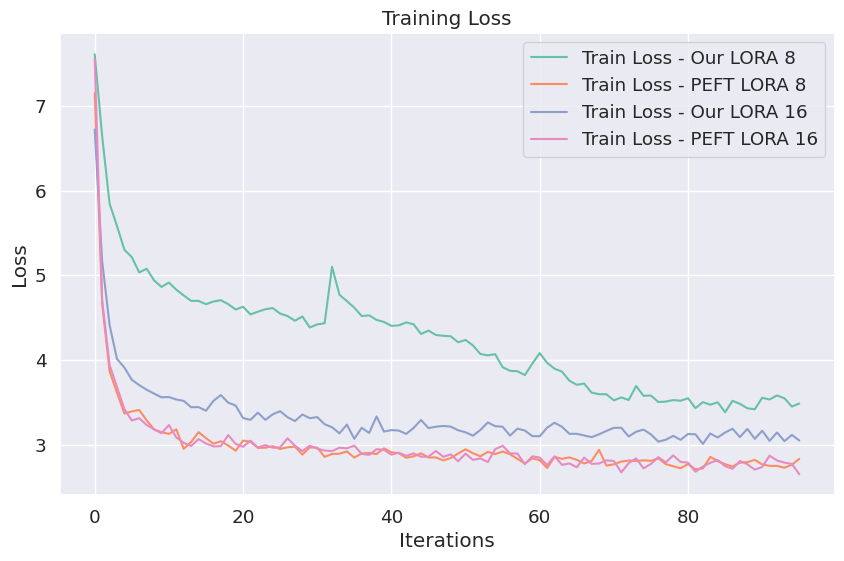

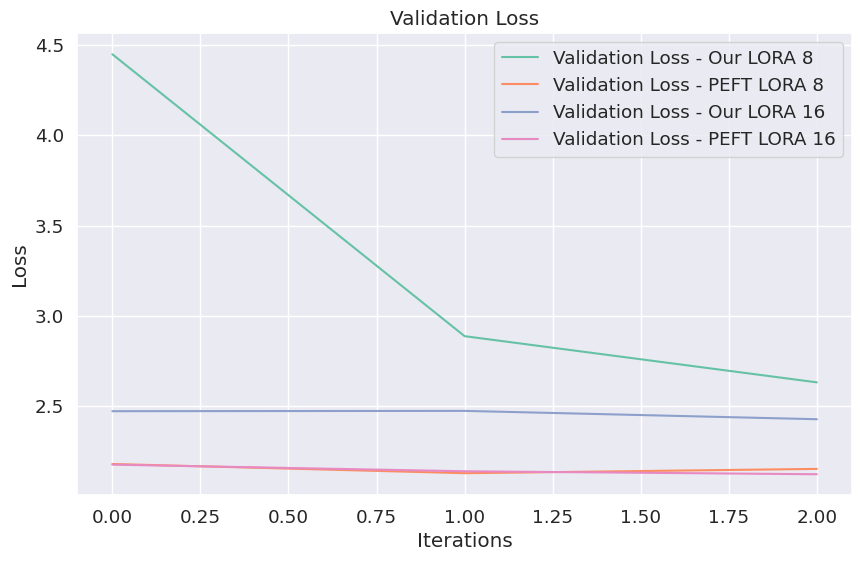

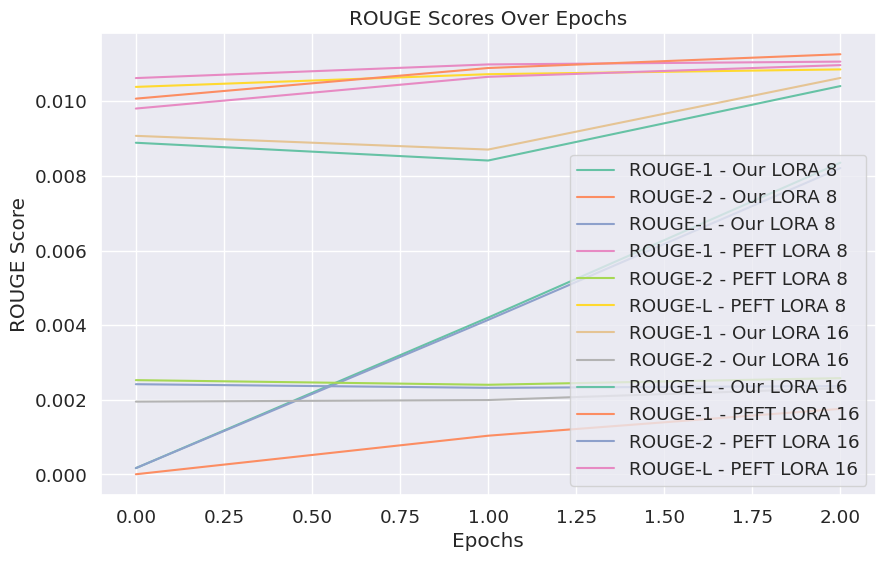

In [31]:
plot_training_results(
    [train_loss_our_lora_8, train_loss_peft_lora_8, train_loss_our_lora_16, train_loss_peft_lora_16],  # Обучающие потери
    [test_loss_our_lora_8, test_loss_peft_lora_8, test_loss_our_lora_16, test_loss_peft_lora_16],      # Валидационные потери
    [test_rogue_our_lora_8, test_rogue_peft_lora_8, test_rogue_our_lora_16, test_rogue_peft_lora_16],  # Метрики ROUGE
    ["Our LORA 8", "PEFT LORA 8", "Our LORA 16", "PEFT LORA 16"]                                       # Названия моделей
)

In [32]:
def generate_and_compare_summary_from_dataset(
    model, tokenizer, dataset, device="cpu", max_length=150, num_beams=5, repetition_penalty=2.0
):
    """
    Генерирует и сравнивает аннотации с использованием beam search и штрафа за повторы.
    
    :param model: Модель генерации текста
    :param tokenizer: Токенизатор
    :param dataset: Датасет с текстами и реальными аннотациями
    :param device: Устройство выполнения ("cpu" или "cuda")
    :param max_length: Максимальная длина генерируемого текста
    :param num_beams: Число лучей в beam search
    :param repetition_penalty: Штраф за повторения
    
    :return: Список кортежей (исходный текст, реальная аннотация, сгенерированная аннотация)
    """
    model.eval()
    generated_texts = []

    for i, data in enumerate(dataset):
        if i >= 5:
            break

        input_text = data['text']
        target_summary = data['summary']

        # Токенизация
        inputs = tokenizer(
            input_text, return_tensors="pt", max_length=256, truncation=True, padding="max_length"
        ).to(device)

        with torch.no_grad():
            output = model.generate(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=max_length,
                num_beams=num_beams,
                repetition_penalty=repetition_penalty,
                early_stopping=True  # Останавливаем beam search, если все лучи дали одинаковый результат
            )

        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        generated_texts.append((input_text, target_summary, generated_text))

    return generated_texts

In [22]:
class IA3LayerWrapper(nn.Module):
    def __init__(self, original_layer):
        super().__init__()
        self.original_layer = original_layer
        self.original_layer.requires_grad_(False)  # Замораживаем исходный слой
        self.ia3_vector = nn.Parameter(torch.ones(original_layer.in_features))

    def forward(self, x):
        scaled_x = self.ia3_vector * x
        return self.original_layer(scaled_x)

    def __getattr__(self, name):
        # Перенаправляем доступ к атрибутам оригинального слоя
        if name in ["weight", "bias"]:  # или другие атрибуты
            return getattr(self.original_layer, name)
        return super().__getattr__(name)

def inject_ia3(model):
    # Внедряем IA3 в энкодер и декодер
    # Энкодер: SelfAttention (k и v)
    for encoder_block in model.encoder.block:
        self_attn = encoder_block.layer[0].SelfAttention
        self_attn.k = IA3LayerWrapper(self_attn.k)
        self_attn.v = IA3LayerWrapper(self_attn.v)

    # Декодер: SelfAttention (k и v) и CrossAttention (k и v)
    for decoder_block in model.decoder.block:
        # Self-attention
        self_attn = decoder_block.layer[0].SelfAttention
        self_attn.k = IA3LayerWrapper(self_attn.k)
        self_attn.v = IA3LayerWrapper(self_attn.v)

        # Cross-attention
        cross_attn = decoder_block.layer[1].EncDecAttention
        cross_attn.k = IA3LayerWrapper(cross_attn.k)
        cross_attn.v = IA3LayerWrapper(cross_attn.v)

    # Внедряем IA3 в выходные слои (feed-forward)
    for name, layer in model.named_modules():
        if "wo" in name and isinstance(layer, nn.Linear):
            wrapped_layer = IA3LayerWrapper(layer)
            # Заменяем исходный слой на обёрнутый
            parent = model
            parts = name.split(".")
            for part in parts[:-1]:
                parent = getattr(parent, part)
            setattr(parent, parts[-1], wrapped_layer)

    # Замораживаем все параметры, кроме IA3-векторов
    for name, param in model.named_parameters():
        if "ia3_vector" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model

In [23]:
# Определение устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 3
# Создание и обучение модели с IA3 через inject_ia3
base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
our_model_ia3 = inject_ia3(base_model)
our_model_ia3 = our_model_ia3.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(our_model_ia3.parameters(), lr=1e-3)

train_loss_our_ia3, test_loss_our_ia3, test_rogue_our_ia3 = train_model_with_rouge(
    our_model_ia3,
    train_dataloader,
    val_dataloader,
    loss_fn,
    optimizer,
    num_epochs,
    device,
    tokenizer
)

Using 2 GPUs!


Epoch 1/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 1/3
Validation Loss: 2.5963
ROUGE-1: 0.0069, ROUGE-2: 0.0013, ROUGE-L: 0.0068


Epoch 2/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 2/3
Validation Loss: 2.3993
ROUGE-1: 0.0083, ROUGE-2: 0.0017, ROUGE-L: 0.0082


Epoch 3/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 3/3
Validation Loss: 2.3401
ROUGE-1: 0.0078, ROUGE-2: 0.0020, ROUGE-L: 0.0077


In [29]:
peft_config_ia3 = IA3Config(
    target_modules=["k", "v", "wo"],  # Выбираем модули для IA3
)

# Применение PEFT к модели с IA3
base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
peft_ia3_model = get_peft_model(base_model, peft_config_ia3)
peft_ia3_model = peft_ia3_model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(peft_ia3_model.parameters(), lr=1e-3)

train_loss_peft_ia3, test_loss_peft_ia3, test_rogue_peft_ia3 = train_model_with_rouge(
    peft_ia3_model,
    train_dataloader,
    val_dataloader,
    loss_fn,
    optimizer,
    num_epochs,
    device,
    tokenizer
)

Using 2 GPUs!


Epoch 1/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 1/3
Validation Loss: 2.5731
ROUGE-1: 0.0071, ROUGE-2: 0.0015, ROUGE-L: 0.0069


Epoch 2/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 2/3
Validation Loss: 2.3849
ROUGE-1: 0.0084, ROUGE-2: 0.0019, ROUGE-L: 0.0083


Epoch 3/3 - training:   0%|          | 0/328 [00:00<?, ?it/s]

validating:   0%|          | 0/82 [00:00<?, ?it/s]

scoring:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 3/3
Validation Loss: 2.3183
ROUGE-1: 0.0085, ROUGE-2: 0.0020, ROUGE-L: 0.0083


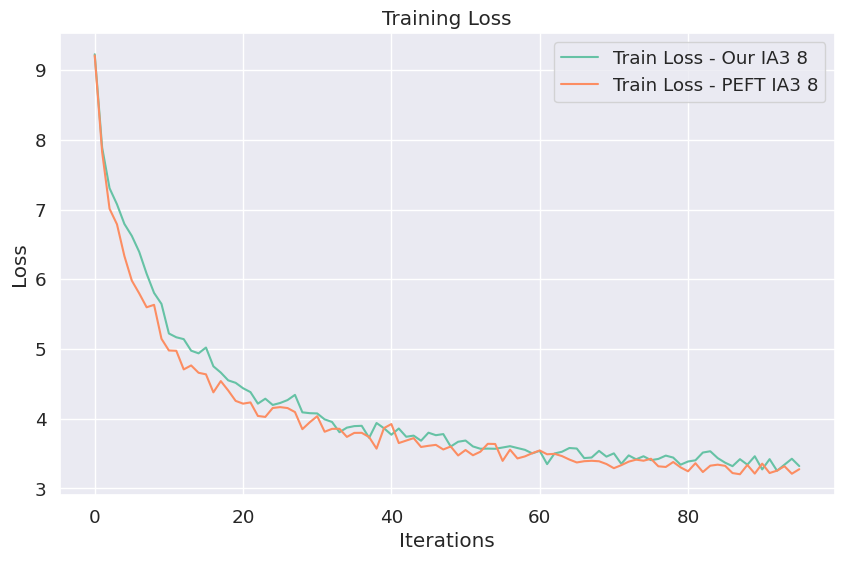

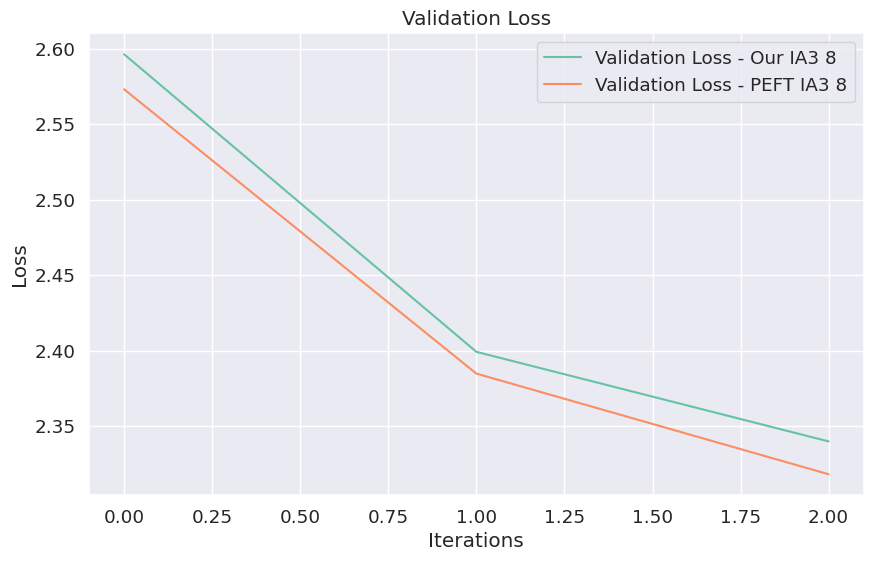

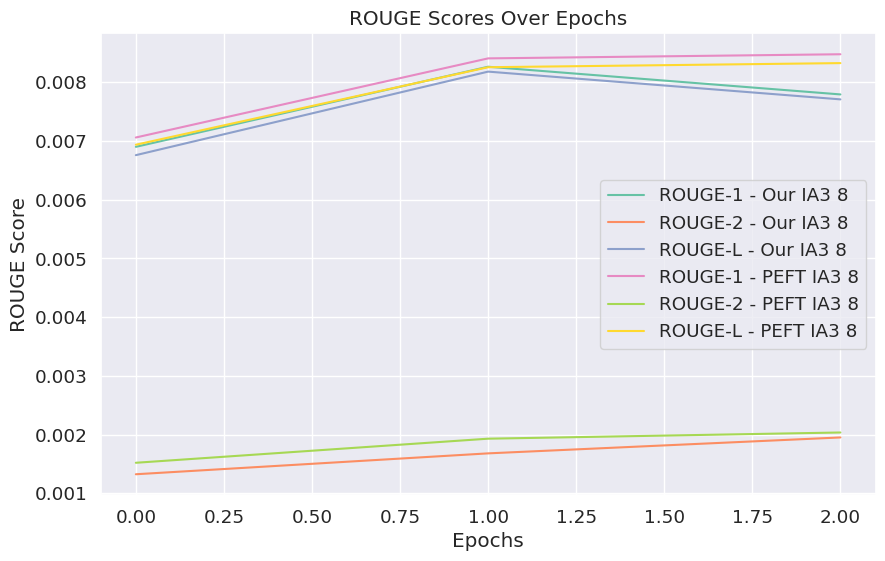

In [30]:
plot_training_results(
    [train_loss_our_ia3, train_loss_peft_ia3],  # Обучающие потери
    [test_loss_our_ia3, test_loss_peft_ia3],      # Валидационные потери
    [test_rogue_our_ia3, test_rogue_peft_ia3],  # Метрики ROUGE
    ["Our IA3 8", "PEFT IA3 8"]                                       # Названия моделей
)

## Оценка качества

Для оценки качества суммаризации можно использовать различные автоматические метрики:
* [BLEU](https://en.wikipedia.org/wiki/BLEU);
* [Rouge](https://en.wikipedia.org/wiki/ROUGE_(metric));
* [METEOR](https://en.wikipedia.org/wiki/METEOR);
* [chrF](https://huggingface.co/spaces/evaluate-metric/chrf).

Сегодня для оценки качества генеративных задач могут использоваться другие, более производительные LLM. Но об этом мы поговорим чуть позже :)

Для сравнения посчитайте число обучаемых параметров для **каждого метода** (включая собственную релазиацию!), измерьте итоговое качество по автоматическим метрикам, а также лосс обученных моделей на валидации и время, затраченное на обучение. Подумайте, какой метод декодирования стоит выбрать для подсчет автометрик?

Обратите внимание на [пост](https://huggingface.co/blog/how-to-generate). Учтите, что для более грамотного сравнения хорошо бы зафиксировать все параметры генерации заранее. Например, можно ограничить максимальную длину генераций в 256 токенов, использововать beam search c фиксированными параметрами `no_repeat_ngram_size=4, num_beams=5` **для всех моделей**.

Для большей наглядности представьте результаты в виде таблицы. Для простоты можно записывать результаты эксперимента в `pd.DataFrame` после каждого запуска.

В этом задании вам предлагается использовать метрику rouge, посчитать ее можно так:

In [ ]:
rouge = evaluate.load("rouge")
predictions = ["Предсказанный текст", "Еше один текст"]
references = ["Истинный текст", "Снова один текст"]

results = rouge.compute(predictions=predictions,
                        references=references,
                        tokenizer=lambda x: x.split())
print(results)

Не пугайтесь, если у вас получатся не нулевые, но плохие результаты.

Качество продемонстрировано выше, использовано rogue

In [ ]:
import pandas as pd

# Формируем DataFrame из последних значений ROUGE
df_rouge = pd.DataFrame([
    {"Model": "Our LORA 8", **test_rogue_our_lora_8[-1]},
    {"Model": "PEFT LORA 8", **test_rogue_peft_lora_8[-1]},
    {"Model": "Our LORA 16", **test_rogue_our_lora_16[-1]},
    {"Model": "PEFT LORA 16", **test_rogue_peft_lora_16[-1]}
])

df_rouge


## Сравнение моделей

Загрузите [модель](https://huggingface.co/IlyaGusev/rut5_base_sum_gazeta), которая обучена на аналогичную задачу, и сравните ее с лучшей из ваших моделей на 2-3 примерах **реальных новостей**. Сделайте выводы.

In [34]:
from transformers import AutoTokenizer, T5ForConditionalGeneration

model_name = "IlyaGusev/rut5_base_sum_gazeta"
good_tokenizer = AutoTokenizer.from_pretrained(model_name)
good_model = T5ForConditionalGeneration.from_pretrained(model_name)
good_model = good_model.to(device)

tokenizer_config.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/766 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/977M [00:00<?, ?B/s]

In [31]:
news = [{
    "text": "В ближайшие пять лет в России ожидается острая нехватка линейного персонала на производственных предприятиях и дефицит кадров в логистике, рассказали РГ эксперты. Нужны люди и в других отраслях. Так, по словам HR и руководителя агентства по подбору и развитию персонала \"Амалко\" Гарри Мурадяна, сейчас на одного сварщика приходится 12 вакансий, на одну швею - 8, на одного менеджера по продажам - 4,2. Эксперт отмечает, что, с одной стороны, дефицит работников связан с демографической ямой, а с другой - с перекрытым потоком трудовых мигрантов. Работодатели назвали гостинг новой проблемой при поиске работников. В результате, отмечает он, сегодня резко выросли зарплаты у особо дефицитных специалистов. Например, тем же сварщикам сегодня предлагают зарплату от 360 тысяч рублей в Москве и от 240 тысяч в регионах. В связи с нехваткой специалистов в ближайшие пять лет будут расти зарплаты у представителей большинства рабочих специальностей, считает директор платформы \"Мигрант Сервис\" Андрей Кладов. В числе ключевых рабочих профессий с высоким потенциалом дохода в ближайшие годы он назвал также курьеров и водителей. Уже сегодня, по его словам, зарплаты курьеров составляют в среднем 155 тысяч рублей в месяц, производственных рабочих - 147 тысяч рублей в месяц, водителей - 136 тысяч рублей в месяц, строителей - 130 тысяч рублей в месяц. При этом в строительстве, отмечает Кладов, зарплаты продолжат расти у работников, занятых непосредственно на строительных площадках: к ним относятся каменщики, бетонщики, крановщики, маляры и другие. Среди водителей спрос останется высоким на тех, кто управляет общественным транспортом, грузовыми машинами и спецтехникой. Также Кладов допустил появление новой разновидности курьеров: таких, которые будут работать удаленно. В доставке они будут использовать новые технологии, в частности, специально разработанные дроны. Ранее министр труда и социального развития Антон Котяков сообщил, что сегодня экономике не хватает 11 млн рабочих рук. Наибольшая потребность в ближайшие годы в специалистах со среднепрофессиональным образованием, рассказал он. По его словам, в течение ближайших пяти лет необходимо подготовить и вовлечь в занятость почти 7 млн таких работников. В их числе нужны станочники и наладчики металлообрабатывающих станков, механики, ремонтники транспортных средств, слесари, сварщики, монтеры электрического оборудования.",
    "summary": "В России прогнозируется нехватка рабочих кадров в производстве, логистике и строительстве из-за демографических факторов и снижения миграции. Зарплаты растут, особенно у сварщиков (до 360 тыс. руб. в Москве), курьеров (155 тыс.), водителей (136 тыс.) и строителей (130 тыс.). Востребованы специалисты со среднепрофессиональным образованием: станочники, слесари, механики. В ближайшие пять лет планируется подготовить 7 млн таких работников. Ожидается рост зарплат и развитие новых форм занятости, включая удалённых курьеров с дронами."
}, {
  "text": "Министерство науки и высшего образования Российской Федерации подвело итоги отбора университетов, которые получат грантовую поддержку по программе «Приоритет 2030». Московский физико-технический институт стал лидером первой группы университетов-участников программы. Вузы этой группы получат максимальные гранты для реализации своих стратегических технологических проектов. Соответствующее решение принял Совет по поддержке программ развития университетов-участников программы стратегического академического лидерства «Приоритет-2030», который провёл оценку актуализированных программ развития российских университетов. Всего в первую группу вошли 11 университетов. В целом грантовая поддержка распространится почти на 100 университетов, распределенных по нескольким группам. Общая сумма финансирования составит около 30 млрд рублей. По словам ректора МФТИ Дмитрия Ливанова, участие в программе «Приоритет-2030» уже позволило Физтеху реализовать мероприятия по созданию научной базы и кадровому обеспечению фундаментальных и поисковых задач развития национальных проектов технологического лидерства; провести консолидацию научно-исследовательской повестки в области микроэлектроники, биомедицины, перспективных накопителей энергии, искусственного интеллекта, а также создать четыре крупных инжиниринговых института, открыть 19 научных лабораторий, в которых работают более 200 профильных высококвалифицированных специалистов. В 2025 году по решению Минобрнауки России программа «Приоритет-2030» была перезапущена, и главным вектором ее обновления стало технологическое лидерство. При этом ключевая цель осталась неизменной – сформировать группу университетов – лидеров научно-технологического и социально-экономического развития страны. Представленная МФТИ программа развития продолжит курс на создание перспективных отечественных технологий. Основная задача университета – перейти от «продажи исследовательских работ» к созданию и выведению на рынки новых технологий.",
  "summary": "МФТИ стал лидером первой группы вузов, получивших максимальные гранты по программе «Приоритет-2030». Всего поддержку получат около 100 университетов, а общий бюджет составит 30 млрд рублей. Программа направлена на технологическое лидерство, развитие микроэлектроники, биомедицины, ИИ и других направлений. МФТИ уже создал четыре инжиниринговых института, 19 лабораторий и привлек 200 специалистов. В 2025 году программа была перезапущена с акцентом на внедрение отечественных технологий. Ключевая цель — переход от научных исследований к созданию и коммерциализации новых технологий."
}]

In [35]:
generated_outputs = generate_and_compare_summary_from_dataset(good_model, good_tokenizer, news, device=device)

# Выводим примеры
for _, target_summary, generated_text in generated_outputs:
    print(f"Target Summary: {target_summary}")
    print(f"Generated Summary: {generated_text}")
    print("-" * 50)

Target Summary: В России прогнозируется нехватка рабочих кадров в производстве, логистике и строительстве из-за демографических факторов и снижения миграции. Зарплаты растут, особенно у сварщиков (до 360 тыс. руб. в Москве), курьеров (155 тыс.), водителей (136 тыс.) и строителей (130 тыс.). Востребованы специалисты со среднепрофессиональным образованием: станочники, слесари, механики. В ближайшие пять лет планируется подготовить 7 млн таких работников. Ожидается рост зарплат и развитие новых форм занятости, включая удалённых курьеров с дронами.
Generated Summary: В ближайшие пять лет в России ожидается острая нехватка линейного персонала на производственных предприятиях и дефицит кадров в логистике, рассказали РГ эксперты. Сейчас на одного сварщика приходится 12 вакансий, на одну швею - 8, на одного менеджера по продажам - 4,2.
--------------------------------------------------
Target Summary: МФТИ стал лидером первой группы вузов, получивших максимальные гранты по программе «Приоритет

Видим, что импортированная модель крайне хороша

In [ ]:
# Пример использования с train_dataset
generated_outputs = generate_and_compare_summary_from_dataset(our_model_lora_16, tokenizer, news, device=device)

# Выводим сгенерированные тексты и соответствующие summary
for input_text, target_summary, generated_text in generated_outputs:
    # print(f"Input Text: {input_text}")
    print(f"Target Summary: {target_summary}")
    print(f"Generated Summary: {generated_text}")
    print("-" * 50)


Текст более менее отражает суть новости. Впрочем невооруженным глазом видна недообученность модели.

In [33]:
# Пример использования с train_dataset
generated_outputs = generate_and_compare_summary_from_dataset(our_model_ia3, tokenizer, news, device=device)

# Выводим сгенерированные тексты и соответствующие summary
for input_text, target_summary, generated_text in generated_outputs:
    # print(f"Input Text: {input_text}")
    print(f"Target Summary: {target_summary}")
    print(f"Generated Summary: {generated_text}")
    print("-" * 50)

Target Summary: В России прогнозируется нехватка рабочих кадров в производстве, логистике и строительстве из-за демографических факторов и снижения миграции. Зарплаты растут, особенно у сварщиков (до 360 тыс. руб. в Москве), курьеров (155 тыс.), водителей (136 тыс.) и строителей (130 тыс.). Востребованы специалисты со среднепрофессиональным образованием: станочники, слесари, механики. В ближайшие пять лет планируется подготовить 7 млн таких работников. Ожидается рост зарплат и развитие новых форм занятости, включая удалённых курьеров с дронами.
Generated Summary: В ближайшие пять лет в России ожидается острая нехватка линейного персонала на производственных предприятиях и дефицит кадров в логистике.
--------------------------------------------------
Target Summary: МФТИ стал лидером первой группы вузов, получивших максимальные гранты по программе «Приоритет-2030». Всего поддержку получат около 100 университетов, а общий бюджет составит 30 млрд рублей. Программа направлена на технологич

**Выводы**

Мы успешно добавили адаптер Lora в трансформер и получили не самые худшие результаты, из за того что моделей для обучения было слишком много мы не смогли получить лучшего качества.